In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

from sklego.metrics import p_percent_score

import warnings
warnings.filterwarnings("ignore")

from fairlearn.widget import FairlearnDashboard

# ML Datasets

We'll load our ml data splits (data has already been split into train and test)

In [2]:
df = pd.read_csv("data/external_Microsoft_issueDataset.csv")
df.head()

,Access Level,BD877Training Completed,Department Code,Email Domain,EmployeeTargetedOverPastYear,Gender (code),Social Media Activity (Scaled),behaviorPattern2,fraudTraining Completed,peerUsageMetric6,usageMetric2,usageMetric5
0,2,0.0,24999,ox.ac.uk,0.0,0,0.0,0,1,5,0,7
1,2,0.0,10000,ox.ac.uk,1.0,1,NaN,0,0,4,0,1
2,0,0.0,10000,si.edu,1.0,1,0.0,0,1,0,0,3
3,2,1.0,54997,si.edu,0.0,0,1.0,1,0,5,1,7
4,1,1.0,10000,si.edu,1.0,1,0.0,2,0,5,0,7


In [3]:
# target column
target_col = "EmployeeTargetedOverPastYear"

# categorical ordinal features
cat_ord_cols = ["Access Level", 
                "behaviorPattern2", 
                "peerUsageMetric6",
                "usageMetric2", 
                "usageMetric5",
                "Social Media Activity (Scaled)"]

# categorical nominal features
cat_nom_cols = ['BD877Training Completed',
                'Department Code', 
                'Email Domain',
                'fraudTraining Completed',
                'Gender (code)']

# no numerical features

In [4]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# X: explanatory variables / y: variable to predict
X_train = train.drop(target_col, axis=1)
y_train = train[[target_col]]

X_test = test.drop(target_col, axis=1)
y_test = test[[target_col]]

# Feature Engineering

Apply feature engineering techniques after data splitting to avoid data leakage.

Let's just rename our preprocessed dataset to avoid confusion with the raw dataset.

In [5]:
X_train_p = X_train.copy()
X_test_p = X_test.copy()

## Imputing NA values

Let's first impute NA values in some of the columns where we have missing data.

Since the columns containing missing values are categorical, we'll impute them with the most frequent value.

In [6]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
missing_cols = cat_ord_cols + cat_nom_cols

X_train_p[missing_cols] = imp.fit_transform(X_train_p[missing_cols])
X_test_p[missing_cols] = imp.transform(X_test_p[missing_cols])

## Z-score scaling of the numerical columns 

In [7]:
#ss = StandardScaler()
#columns to scale with the standard scaler
#ss_cols = num_cols

#X_train_p[ss_cols] = ss.fit_transform(X_train_p[ss_cols])
#X_test_p[ss_cols] = ss.transform(X_test_p[ss_cols])

## Min-Max scaling of the ordinal categorical columns

In [8]:
mmc = MinMaxScaler()
#columns to scale with the min max scaler
mmc_cols = cat_ord_cols

X_train_p[mmc_cols] = mmc.fit_transform(X_train_p[mmc_cols])
X_test_p[mmc_cols] = mmc.transform(X_test_p[mmc_cols])

## One-hot encoding of the nominal categorical columns

In [9]:
# if binary categorical, no need for 2 columns
ohe = OneHotEncoder(drop = "if_binary", sparse=False)

# Define categorical to be one hot encoded
ohe_cols = cat_nom_cols

# Encode categorical columns, and store results in a new dataframe
X_train_encoded = pd.DataFrame(ohe.fit_transform(X_train_p[ohe_cols]), index=X_train_p.index)
X_test_encoded = pd.DataFrame(ohe.transform(X_test_p[ohe_cols]), index=X_test_p.index)

# Retrieve encoded columns names
X_train_encoded.columns = ohe.get_feature_names(ohe_cols)
X_test_encoded.columns = ohe.get_feature_names(ohe_cols)

# Drop initial columns 
X_train_p.drop(ohe_cols ,axis=1, inplace=True)
X_test_p.drop(ohe_cols ,axis=1, inplace=True)

# Add encoded columns to initial dataset
X_train_p = pd.concat([X_train_p, X_train_encoded], axis=1)
X_test_p = pd.concat([X_test_p, X_test_encoded ], axis=1)

# Random Forest Modeling and Hyperparameter Tuning

Random forest uses bagging (picking a sample of observations rather than all of them) and random subspace method (picking a sample of features rather than all of them, in other words - attribute bagging) to grow a tree.

#### Tuning the number of estimators (trees)

Increasing the number of trees in the forest decreases the variance of the overall model, and doesn't contribute to overfitting. More trees also mean more computational cost and after a certain number of trees, the improvement is negligible. 
 
So let's first monitor generalization performance while sequentially adding new trees to the model, then we'll pick the number of trees when performance plateaus. 

In [10]:
# Create the random grid
param_grid = { # Number of trees in random forest
               'n_estimators': [5, 10, 50, 100, 150] + [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)] + [2000]
                }

rf = RandomForestClassifier(random_state=0)
rf_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, verbose=1, scoring="accuracy")
rf_search = rf_search.fit(X_train_p, y_train)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


Text(0.5, 1.0, 'CV Accuracy vs Number of Trees')

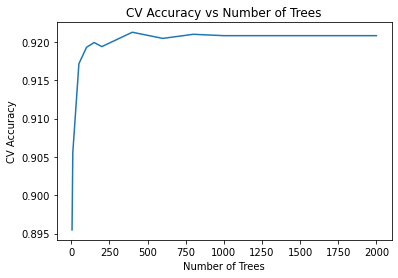

In [11]:
plt.plot([i['n_estimators'] for i in rf_search.cv_results_['params']], 
         rf_search.cv_results_['mean_test_score'])

plt.xlabel("Number of Trees")
plt.ylabel("CV Accuracy")
plt.title("CV Accuracy vs Number of Trees")

In [12]:
# Create the random grid
random_grid = { # split impurity metric
                'criterion': ['gini', 'entropy'],
                # Number of features to consider at every split
               'max_features': ['auto', 'sqrt', 'log2'],
                # Maximum number of levels in tree
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
                # Minimum number of samples required to split a node
               'min_samples_split': [2, 5] + [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
                # Minimum number of samples required at each leaf node
               'min_samples_leaf': [1, 5] + [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
                # Method of selecting samples for training each tree
               'bootstrap': [True, False]}

rf = RandomForestClassifier(random_state=0, n_estimators=250)
rf_search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=1, random_state=0, scoring="accuracy")
rf_search = rf_search.fit(X_train_p, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [13]:
# predicting over training & testing datasets
y_train_pred = rf_search.predict(X_train_p)
y_test_pred = rf_search.predict(X_test_p)

#Printing the first 10 predictions:
y_test_pred[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Evaluating Random Forest Model

### Evaluation over training set

In [14]:
metrics.confusion_matrix(y_train, y_train_pred)

array([[2401,  620],
       [ 253, 7940]])

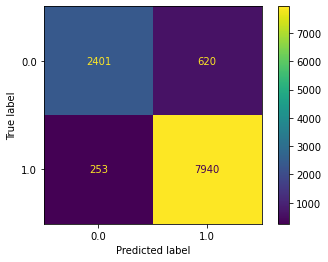

In [15]:
metrics.plot_confusion_matrix(rf_search, X_train_p, y_train)

In [16]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_train, y_train_pred))
# Recall
print("Recall:",metrics.recall_score(y_train, y_train_pred))
# Precision
print("Precison:",metrics.precision_score(y_train, y_train_pred))
# F1score
print("F1 Score:",metrics.f1_score(y_train, y_train_pred))

Accuracy: 0.9221508828250401
Recall: 0.9691199804711339
Precison: 0.927570093457944
F1 Score: 0.947889930161762


Let's estimate, how accurately the classifier or model can predict on new data.

Accuracy can be computed by comparing actual test set values and predicted values.

### Evaluation over testing set

In [17]:
metrics.confusion_matrix(y_test, y_test_pred)

array([[ 555,  181],
       [  54, 1996]])

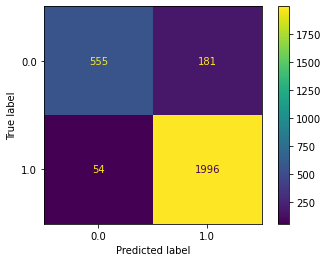

In [18]:
metrics.plot_confusion_matrix(rf_search, X_test_p, y_test)

In [19]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_test_pred))
# Recall
print("Recall:",metrics.recall_score(y_test, y_test_pred))
# Precision
print("Precison:",metrics.precision_score(y_test, y_test_pred))
# F1score
print("F1 Score:",metrics.f1_score(y_test, y_test_pred))

Accuracy: 0.9156496769562096
Recall: 0.9736585365853658
Precison: 0.9168580615525953
F1 Score: 0.944405015377336
